# Data analysis: Covid cases over time

Data analysis of daily new covid cases in different countries, using data from:

https://github.com/CSSEGISandData/COVID-19

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

In [2]:
plt.style.use("ggplot")

## Import and clean up data

In [3]:
df = pd.read_csv("time_series_covid19_confirmed_global.csv")

In [4]:
df.head(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,57242,57364,57492,57534,57612,57721,57793,57898,58037,58214
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,128518,128752,128959,129128,129307,129456,129594,129694,129842,129980
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,118645,118799,118975,119142,119323,119486,119642,119805,119992,120174


### Remove unused columns

In [5]:
df = df.drop(["Lat", "Long"], axis=1)

In [6]:
df.head(3)

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,57242,57364,57492,57534,57612,57721,57793,57898,58037,58214
1,NaN,Albania,0,0,0,0,0,0,0,0,...,128518,128752,128959,129128,129307,129456,129594,129694,129842,129980
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,118645,118799,118975,119142,119323,119486,119642,119805,119992,120174


### Convert from wide format to long

In [7]:
df = df.melt(id_vars=["Province/State", "Country/Region"], var_name="Date", value_name="Cases")

In [8]:
df.head(3)

,Province/State,Country/Region,Date,Cases
0,NaN,Afghanistan,1/22/20,0
1,NaN,Albania,1/22/20,0
2,NaN,Algeria,1/22/20,0


### Make values in date column proper dates

In [9]:
df.dtypes

Province/State    object
Country/Region    object
Date              object
Cases              int64
dtype: object

In [10]:
df["Date"] = pd.to_datetime(df["Date"])

In [11]:
df.dtypes

Province/State            object
Country/Region            object
Date              datetime64[ns]
Cases                      int64
dtype: object

In [12]:
df.head(3)

,Province/State,Country/Region,Date,Cases
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0


### Sum provinces, aggregate to country level

In [13]:
df[(df["Country/Region"] == "United Kingdom") & 
   (df["Date"] == pd.to_datetime("2021-01-01"))]

,Province/State,Country/Region,Date,Cases
94783,Anguilla,United Kingdom,2021-01-01,13
94784,Bermuda,United Kingdom,2021-01-01,604
94785,British Virgin Islands,United Kingdom,2021-01-01,86
94786,Cayman Islands,United Kingdom,2021-01-01,338
94787,Channel Islands,United Kingdom,2021-01-01,3059
94788,Falkland Islands (Malvinas),United Kingdom,2021-01-01,29
94789,Gibraltar,United Kingdom,2021-01-01,2212
94790,Isle of Man,United Kingdom,2021-01-01,377
94791,Montserrat,United Kingdom,2021-01-01,13
94792,"Saint Helena, Ascension and Tristan da Cunha",United Kingdom,2021-01-01,4


In [14]:
df = df.groupby(["Country/Region", "Date"], as_index=False).sum()

In [15]:
df[(df["Country/Region"] == "United Kingdom") &
   (df["Date"] == pd.to_datetime("2021-01-01"))]

,Country/Region,Date,Cases
83337,United Kingdom,2021-01-01,2549693


### Convert cumulative total to daily new cases

In [16]:
df[(df["Country/Region"] == "Poland") &
   (df["Date"] >= pd.to_datetime("2021-01-01")) &
   (df["Date"] <= pd.to_datetime("2021-01-03"))]

,Country/Region,Date,Cases
63273,Poland,2021-01-01,1305774
63274,Poland,2021-01-02,1312780
63275,Poland,2021-01-03,1318562


In [17]:
df["Cases"] = df.groupby("Country/Region")["Cases"].transform("diff")

In [18]:
df[(df["Country/Region"] == "Poland") &
   (df["Date"] >= pd.to_datetime("2021-01-01")) &
   (df["Date"] <= pd.to_datetime("2021-01-03"))]

,Country/Region,Date,Cases
63273,Poland,2021-01-01,10896.0
63274,Poland,2021-01-02,7006.0
63275,Poland,2021-01-03,5782.0


## Analyze

In [19]:
date_from = pd.to_datetime("2021-01-01")
date_to   = pd.to_datetime("2021-04-22")

countries = sorted([
    "Poland",
    "Czechia",
    "Germany",
    "Austria"
])

### Day by day plot

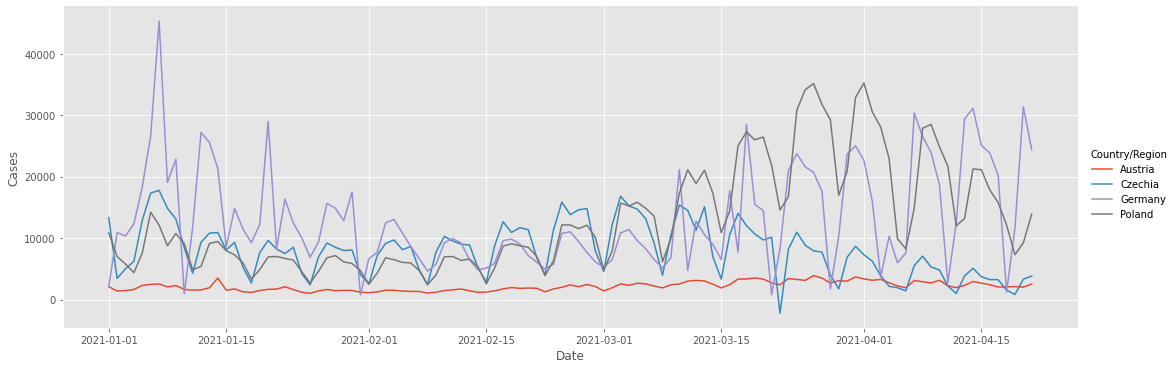

In [20]:
def cases_day_by_day():
    return df[df["Country/Region"].isin(countries) &
              (df["Date"] >= date_from) &
              (df["Date"] <= date_to)]

sns.relplot(data=cases_day_by_day(), x="Date", y="Cases", hue="Country/Region", kind="line", aspect=3)

### Week by week plot

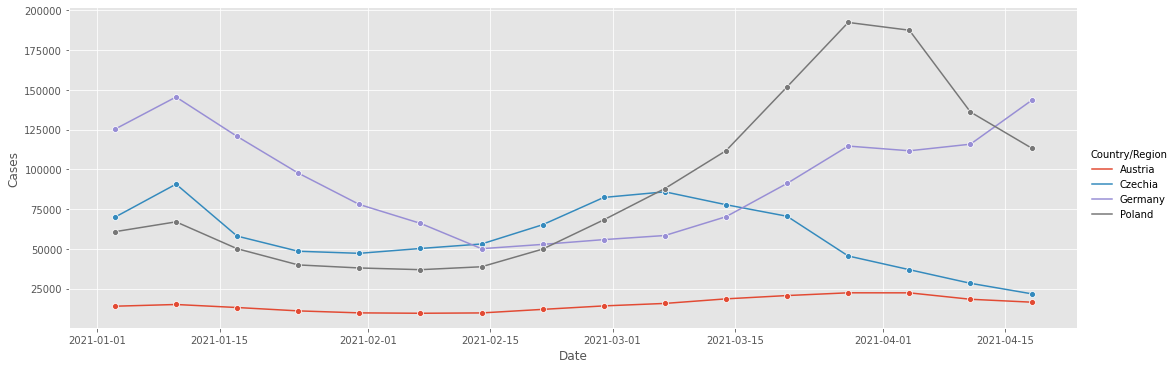

In [21]:
def cases_week_by_week():
    def week_start(dt):
        return dt - timedelta(days=dt.weekday())

    return (
        df[df["Country/Region"].isin(countries) &
           (df["Date"] >= week_start(date_from)) &
           (df["Date"] < week_start(date_to))]
        .groupby("Country/Region")
        .resample("1W", on="Date")
        .sum()
    )

sns.relplot(data=cases_week_by_week(), x="Date", y="Cases", hue="Country/Region", kind="line", marker="o", aspect=3)

### 7 day moving average plot

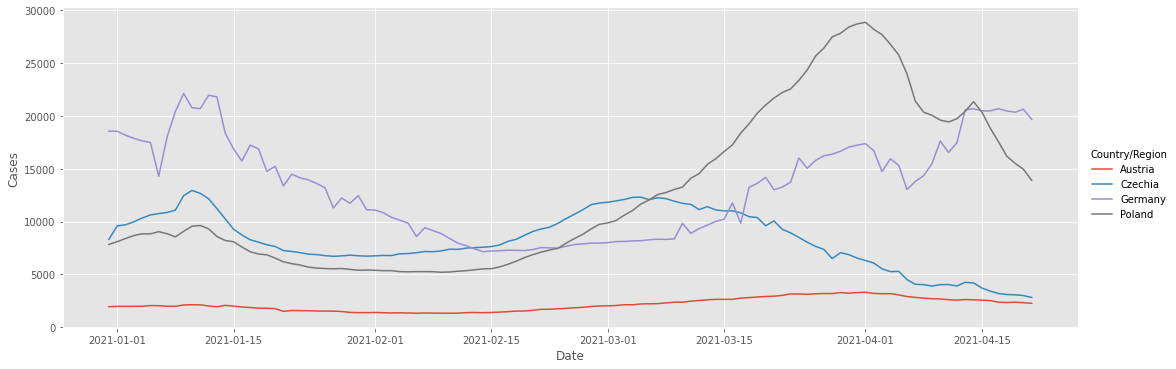

In [22]:
def cases_moving_average(days):
    # To compute the moving average you need more days than will be presented
    ma_date_from = date_from - timedelta(days=days)

    return (
        df[df["Country/Region"].isin(countries) &
           (df["Date"] >= ma_date_from) &
           (df["Date"] <= date_to)]
        .groupby("Country/Region")
        .rolling(days, on="Date")
        .mean()
    )

sns.relplot(data=cases_moving_average(7), x="Date", y="Cases", hue="Country/Region", kind="line", aspect=3)